### ### Project #2 Atari game PONG

In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import imageio
import matplotlib.pyplot as plt
import time

In [2]:
# hyperparameter
ENV_NAME = 'ALE/Pong-ram-v5'
state_size = 128        # 입력으로 받을 상태의 차원
action_size = 6         # 액션 수
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
learning_rate = 0.00025
num_episodes = 1000
memory_size = 50000
update_target_every = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define the DQN Agent's neural network
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNAgent, self).__init__()
        # Input layer
        self.fc1 = nn.Linear(state_size, 256)
        # Hidden layer
        self.fc2 = nn.Linear(256, 256)
        # Output layer
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        # Normalize the input
        x = x / 255.0
        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Define the Agent class
class Agent:
    def __init__(self, state_size, action_size):
        # Main network and target network
        self.model = DQNAgent(state_size, action_size).to(device)
        self.target_model = DQNAgent(state_size, action_size).to(device)
        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # Replay buffer
        self.memory = deque(maxlen=memory_size)
        # Exploration rate
        self.epsilon = epsilon

    def remember(self, state, action, reward, next_state, done):
        # Store experience in replay buffer
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon-greedy action selection
        if random.random() <= self.epsilon:
            # Explore: select a random action
            return random.randrange(action_size)
        # Exploit: select the action with max Q-value
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        # Training the network using replay buffer
        if len(self.memory) < batch_size:
            return
        # Sample a minibatch from the replay buffer
        minibatch = random.sample(self.memory, batch_size)

        # Convert minibatch to tensors efficiently
        states = torch.from_numpy(np.vstack([m[0] for m in minibatch])).float().to(device)
        actions = torch.from_numpy(np.vstack([m[1] for m in minibatch])).long().to(device)
        rewards = torch.from_numpy(np.vstack([m[2] for m in minibatch])).float().to(device)
        next_states = torch.from_numpy(np.vstack([m[3] for m in minibatch])).float().to(device)
        dones = torch.from_numpy(np.vstack([float(m[4]) for m in minibatch])).float().to(device)

        # Calculate Q-values
        q_values = self.model(states).gather(1, actions)
        # Calculate target Q-values
        next_q_values = self.target_model(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (gamma * next_q_values * (1 - dones))

        # Compute loss and update the network
        loss = F.mse_loss(q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_model(self):
        # Update the target network
        self.target_model.load_state_dict(self.model.state_dict())

In [7]:
#env = gym.make(ENV_NAME)
env = gym.make(ENV_NAME, render_mode="rgb_array")
agent = Agent(state_size, action_size)

rewards_list = []
best_reward = -float('inf')
best_frames = []


In [8]:
start = time.time()
# Training loop
for e in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)

        # Agent selects an action
        action = agent.act(state)
        # Environment returns next state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        # Store the experience in memory
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        # Agent learns from the experience
        agent.replay()
    # Update the target network periodically
    if e % update_target_every == 0:
        agent.update_target_model()
    # Decay the exploration rate
    if agent.epsilon > epsilon_min:
        agent.epsilon *= epsilon_decay
    # Append the total reward for this episode
    rewards_list.append(total_reward)
    if total_reward > best_reward:
        best_reward = total_reward
        best_frames = frames

    # Print the progress
    print(f"Episode: {e+1}/{num_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")
    # Early stopping if desired performance is reached
    if total_reward >= 20:
        print("Desired performance achieved, stopping training.")
        break

end = time.time()
length = end - start
# Show the results : this can be altered however you like
print("It took", length, "seconds!")

/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1/1000, Score: -21.0, Epsilon: 0.99
Episode: 2/1000, Score: -21.0, Epsilon: 0.99
Episode: 3/1000, Score: -21.0, Epsilon: 0.99
Episode: 4/1000, Score: -20.0, Epsilon: 0.98
Episode: 5/1000, Score: -21.0, Epsilon: 0.98
Episode: 6/1000, Score: -20.0, Epsilon: 0.97
Episode: 7/1000, Score: -21.0, Epsilon: 0.97
Episode: 8/1000, Score: -21.0, Epsilon: 0.96
Episode: 9/1000, Score: -21.0, Epsilon: 0.96
Episode: 10/1000, Score: -21.0, Epsilon: 0.95
Episode: 11/1000, Score: -20.0, Epsilon: 0.95
Episode: 12/1000, Score: -20.0, Epsilon: 0.94
Episode: 13/1000, Score: -20.0, Epsilon: 0.94
Episode: 14/1000, Score: -20.0, Epsilon: 0.93
Episode: 15/1000, Score: -20.0, Epsilon: 0.93
Episode: 16/1000, Score: -19.0, Epsilon: 0.92
Episode: 17/1000, Score: -18.0, Epsilon: 0.92
Episode: 18/1000, Score: -20.0, Epsilon: 0.91
Episode: 19/1000, Score: -17.0, Epsilon: 0.91
Episode: 20/1000, Score: -21.0, Epsilon: 0.90
Episode: 21/1000, Score: -21.0, Epsilon: 0.90
Episode: 22/1000, Score: -21.0, Epsilon: 0.

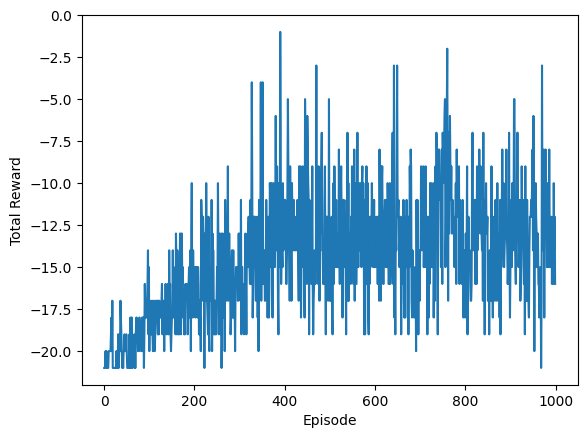

Best episode reward: -1.0


In [9]:
from common.utils import plot_total_reward
plot_total_reward(rewards_list)

env.close()
print(f"Best episode reward: {best_reward}")

Best episode saved as best_Pong_game.gif


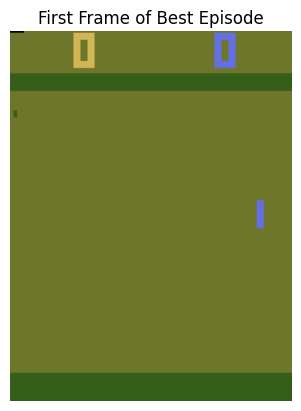

In [10]:
# 이미지로 저장
output_filename = "best_Pong_game.gif"
imageio.mimsave(output_filename, best_frames, fps=30)
print(f"Best episode saved as {output_filename}")

# 첫 장면만 시각화
plt.imshow(best_frames[0])
plt.title("First Frame of Best Episode")
plt.axis('off')
plt.show()